# Computing Objective Functions on the Raven server

Here we use birdy's WPS client to compare simulated and observed discharge using various objective functions on the server.

In [1]:
import os
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

First, we run GR4JCN to generate a NetCDF file containing `q_obs` and `q_sim`.
This file contains `q_obs` from the initial dataset, plus the simulated discharge `q_sim` from the model.

In [2]:
# The model parameters. Can either be a string of comma separated values, a list, an array or a named tuple. 
params = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'

# Forcing files
ts=TESTDATA['raven-gr4j-cemaneige-nc-ts']

# Model configuration parameters
config = dict(
    start_date=dt.datetime(2000, 1, 1),
    end_date=dt.datetime(2002, 1, 1),
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    )

# Let's call the model
resp = wps.raven_gr4j_cemaneige(ts=str(ts), params = params, **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally.
# Here we use false, as we do not want the file, we only want the path to the file.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=False)

Now we can call the objective function WPS service on the Raven Server and collect the results using 'asobj=True' to collect the actual results in a dict format.

In [3]:
resp = wps.objective_function(obs=hydrograph, sim=hydrograph)
results=resp.get(asobj=True)

Let's see the results!

In [4]:
print(results.metrics)

{'agreementindex': 0.45966283668779995, 'bias': 3.264415081640664, 'correlationcoefficient': 0.20692429156109987, 'covariance': 126.58541245493183, 'decomposed_mse': 1336.7774546759213, 'kge': 0.04155565323313137, 'log_p': -86.28634354147955, 'lognashsutcliffe': -1.7249359886326232, 'mae': 24.444255591828355, 'mse': 1336.7774546759213, 'nashsutcliffe': -0.037104791790125935, 'pbias': -11.66639985156869, 'rmse': 36.56196732502124, 'rrmse': 1.3066553103881289, 'rsquared': 0.042817662438063064, 'rsr': 1.0183834208146387, 'volume_error': -0.11666399851568689}


There are 17 objective functions. We can also call the WPS server with any one of those objective functions:

In [5]:
resp = wps.objective_function(obs=hydrograph, sim=hydrograph, name='agreementindex')
results=resp.get(asobj=True)
print(results.metrics)

{'agreementindex': 0.45966283668779995}


Now that we have numerical values for the goodness-of-fit, let's perform a visual inspection.

In [6]:
# Rerun the model but this time get the object (asobj=True)
resp2 = wps.raven_gr4j_cemaneige(ts=str(ts), params = params, **config)
[hydrograph, storage, solution, diagnostics, rv] = resp2.get(asobj=False)


In [7]:
# Call the objective function graphing wps while sending the hydrograph as input, which includes 'q_sim' and 'q_obs'
resp3=wps.graph_objective_function_fit(sims=hydrograph)
[graph_objfun_fit, graph_objfun_annual_fit] = resp3.get(asobj=True)


Now that we have run the graphing service, display the plots.

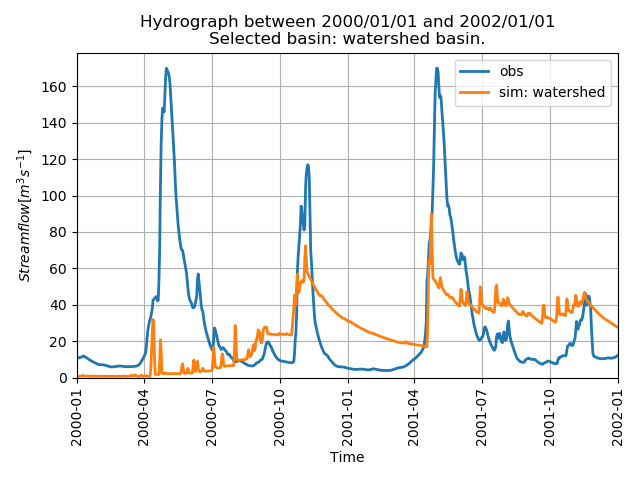

In [8]:
# Graph of full time series
graph_objfun_fit